In [7]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.utils import pad_sequences
from keras.preprocessing.text import one_hot
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords

In [2]:
df = pd.read_csv('data/train.csv')

In [3]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [4]:
# Drop the missing values
df.dropna(inplace=True)

In [5]:
X = df.drop('label', axis=1)
y = df['label']

In [6]:
y.value_counts()

label
0    10361
1     7924
Name: count, dtype: int64

In [8]:
vocab_size = 5000

In [9]:
messages = X.copy()

In [10]:
messages['title'][1]

'FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart'

In [11]:
messages.reset_index(inplace=True)

In [12]:
# Data Preprocessing
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus = []
for i in range(0,len(messages)):
    # remove all the special characters except a-z and A-Z
    review = re.sub('[^a-zA-Z]', ' ', messages['title'][i])
    review = review.lower()
    review = review.split()
    # Stemming and removing stopwords
    review = [ps.stem(word) for word in review if word not in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [13]:
onehot_representation = [one_hot(words,vocab_size) for words in corpus]

In [14]:
# Pad Sequences to make all the sentences of same length
max_length = 20
pad_sequences_representation = pad_sequences(onehot_representation, padding = 'pre', maxlen=max_length)
print(pad_sequences_representation)

[[   0    0    0 ... 1295 4029 3682]
 [   0    0    0 ... 3000 2536  433]
 [   0    0    0 ... 2378 4441 2725]
 ...
 [   0    0    0 ... 1024 1113  240]
 [   0    0    0 ... 4357 2236 1419]
 [   0    0    0 ... 1460 4698 2563]]


In [15]:
embedding_features = 40
model = Sequential()
model.add(Embedding(vocab_size, embedding_features, input_length=max_length))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 40)            200000    
                                                                 
 bidirectional (Bidirectiona  (None, 200)              112800    
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 313,001
Trainable params: 313,001
Non-trainable params: 0
_________________________________________________________________


In [16]:
X_final = np.array(pad_sequences_representation)
y_final = np.array(y)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.3, random_state=42)

In [18]:
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64)

Epoch 1/10
200/200 [==============================] - 28s 92ms/step - loss: 0.2934 - accuracy: 0.8643 - val_loss: 0.2041 - val_accuracy: 0.9129
Epoch 2/10
200/200 [==============================] - 18s 88ms/step - loss: 0.1340 - accuracy: 0.9492 - val_loss: 0.2035 - val_accuracy: 0.9174
Epoch 3/10
200/200 [==============================] - 18s 92ms/step - loss: 0.0929 - accuracy: 0.9657 - val_loss: 0.2435 - val_accuracy: 0.9178
Epoch 4/10
200/200 [==============================] - 18s 92ms/step - loss: 0.0632 - accuracy: 0.9791 - val_loss: 0.3080 - val_accuracy: 0.9127
Epoch 5/10
200/200 [==============================] - 19s 97ms/step - loss: 0.0471 - accuracy: 0.9845 - val_loss: 0.3361 - val_accuracy: 0.9112
Epoch 6/10
200/200 [==============================] - 17s 83ms/step - loss: 0.0352 - accuracy: 0.9895 - val_loss: 0.3608 - val_accuracy: 0.9110
Epoch 7/10
200/200 [==============================] - 15s 75ms/step - loss: 0.0244 - accuracy: 0.9929 - val_loss: 0.3845 - val_accuracy:

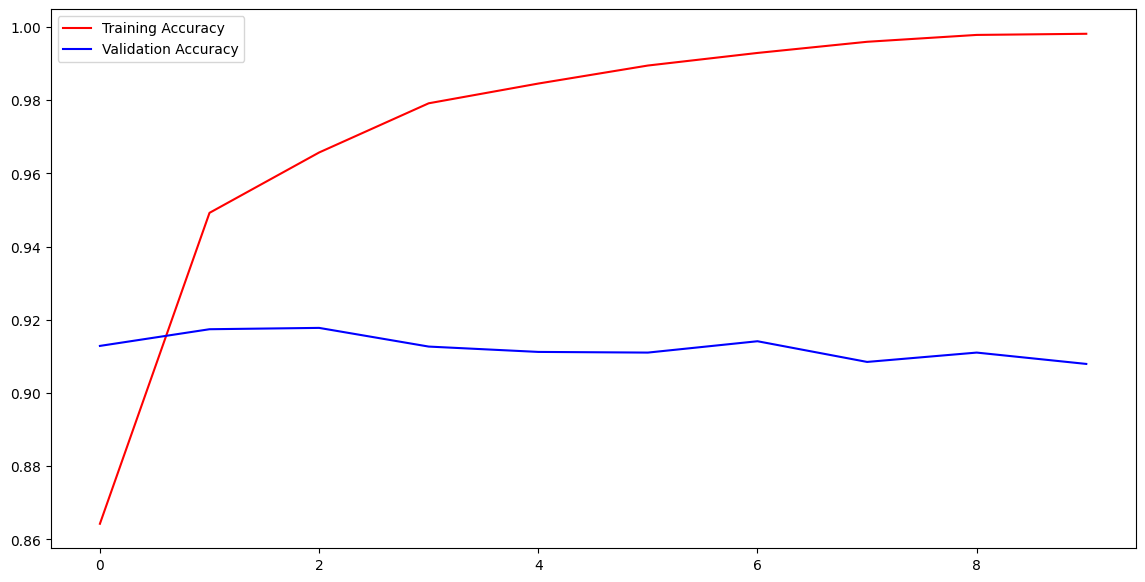

In [19]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(len(acc))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,acc,'r',label="Training Accuracy")
plt.plot(epochs,val_acc,'b',label="Validation Accuracy")
plt.legend(loc='upper left')
plt.show()

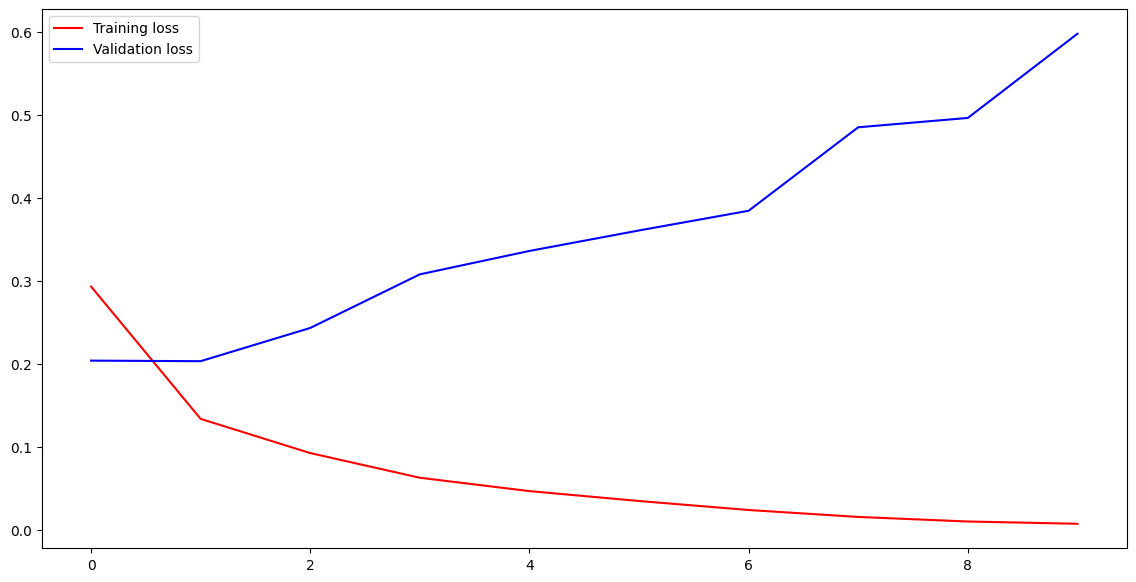

In [20]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(len(loss))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,loss,'r',label="Training loss")
plt.plot(epochs,val_loss,'b',label="Validation loss")
plt.legend(loc='upper left')
plt.show()

In [21]:
y_pred = model.predict(X_test)

172/172 [==============================] - 3s 11ms/step


In [22]:
cm = confusion_matrix(y_test, y_pred.round())
cm

array([[2812,  295],
       [ 210, 2169]], dtype=int64)

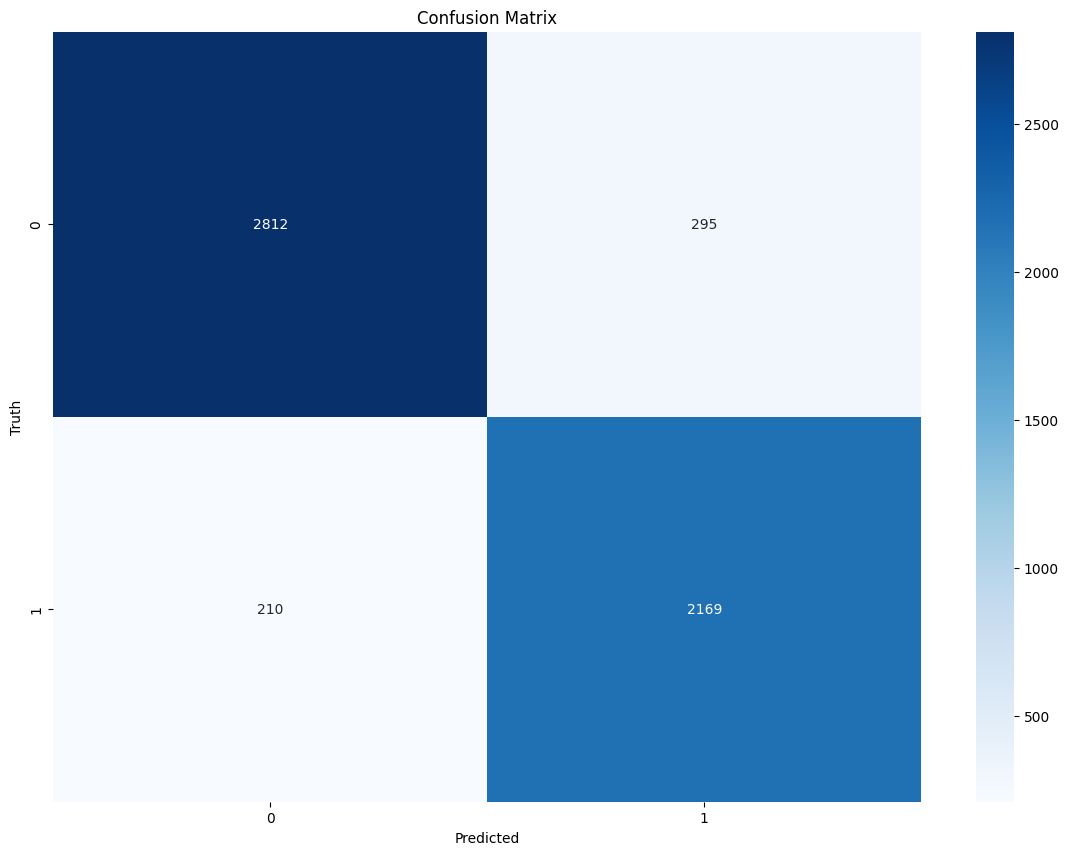

In [23]:
plt.figure(figsize=(14,10))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [24]:
print(accuracy_score(y_test, y_pred.round()))

0.9079475027342326
